In [2]:
#import packages
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as stats

#for visualization
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

#Code developed by C. Bertossa for hw1 of AOS 575 UW-Madison (questions written by E. Maroon)

In [3]:
nino34 = xr.open_dataset('./nino34.nc').nino34

slp = xr.open_dataset('./erai_surffields_1979-2018.nc').msl
print(nino34, '\n\n\n', slp)

<xarray.DataArray 'nino34' (time: 456)>
array([-0.296218, -0.002731,  0.223252, ..., -0.95585 , -0.984631, -0.888912])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Attributes:
    description:  Monthly Nino 3.4 index calculated from HadISST. 1979-2016 m...
    author:       Elizabeth Maroon
    date:         9/20/2020
    units:        degrees C 


 <xarray.DataArray 'msl' (time: 480, latitude: 241, longitude: 480)>
[55526400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level


Text(0, 0.5, 'SLP Stdzed')

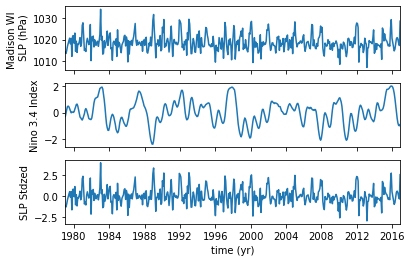

In [4]:
#a.Subselect the ERA-I SLP dataset to be the same length as the Niño3.4 time series (1979-2016).
#Make and turn in two time series plots, one for the Niño3.4 index and one for SLP selected from the nearest grid box to Madison (-89.40, 43.07). 

#select only intersecting months
time_ix = np.isin(slp.time, nino34.time)
slp = slp.sel(time=time_ix)

#coords for Madison WI
mlon, mlat = -89.40, 43.07

fig, ax= plt.subplots(3,1, sharex=True)
ax[0].plot(slp.time, slp.sel(latitude=mlat, longitude=mlon, method='nearest')/100)
ax[1].plot(nino34.time, nino34)
ax[2].set_xlabel('time (yr)')
ax[1].set_xlim(slp.time[0],slp.time[-1])
ax[0].set_ylabel('Madison WI \n SLP (hPa)')
ax[1].set_ylabel('Nino 3.4 Index')

#b.Standardize the SLP dataset for every location. Subtract the mean and divide by the standard deviation.
#Replot and turn in a time series of standardized SLP again at Madison check that the standardization worked.
slp_std = (slp - slp.mean('time'))/slp.std('time')
ax[2].plot(slp.time, slp_std.sel(latitude=mlat, longitude=mlon, method='nearest'))
ax[2].set_ylabel('SLP Stdzed')

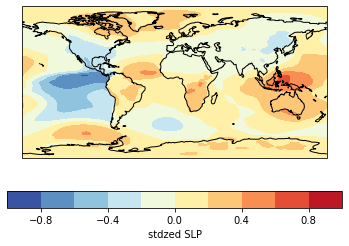

In [5]:
#c.Subselect standardized SLP when Niño3.4 is greater than +0.4 (El Niño).  
#Calculate the composite mean of SLP for El Niño months and make a map of it.
fig = plt.figure()
ax= fig.add_subplot(1,1,1,projection= ccrs.PlateCarree())

slp_std_sel = slp_std.where(nino34>0.4, np.nan)
cf=ax.contourf(slp_std.longitude, slp_std.latitude, slp_std_sel.mean('time'), cmap='RdYlBu_r', levels=np.arange(-1,1.1,0.2), transform = ccrs.PlateCarree()) 
ax.coastlines()
plt.colorbar(cf, label='stdzed SLP', orientation='horizontal')
plt.show()

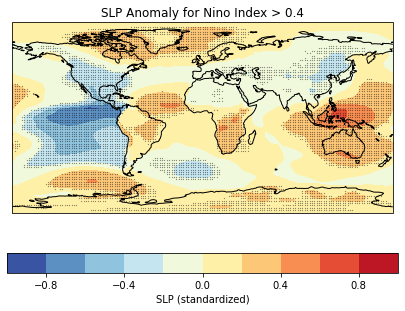

In [6]:
#d.Visualize where the composite (sample) mean of SLP is different from the population mean at 95% significance (two-tailed) by stippling the significant points

#first solve for z-stat for every location
# sample_mean - pop_mean / (sample_std/sqrt(N))

sample_mean = np.mean(slp_std_sel, axis=0)
sample_std =   np.std(slp_std_sel, axis=0)
N = slp_std_sel.count('time') #note that N varies F(lat,lon)!

#calc z
z_stat = (sample_mean - 0)/(sample_std/np.sqrt(N))

#corresponds to 95% significance for 2 tail
z_crit = 1.96

#make a meshgrid of lat,lon
xx,yy = np.meshgrid(slp_std.longitude, slp_std.latitude)
#set those values less than the z_crit as nan, to not include in stippling
xx[np.abs(z_stat) < z_crit]= np.nan
yy[np.abs(z_stat) < z_crit] = np.nan

#plot results
fig = plt.figure(figsize=(7,5))
ax= fig.add_subplot(1,1,1,projection= ccrs.PlateCarree())
ax.coastlines()

#plot composite
cf=ax.contourf(slp_std.longitude, slp_std.latitude, slp_std_sel.mean('time'), cmap='RdYlBu_r', levels=np.arange(-1,1.1,0.2), transform = ccrs.PlateCarree()) 
#stipple significant locations, thin to make a little easier to see
ax.scatter(xx[::3,::3],yy[::3,::3],color = 'k', s= 0.03,transform = ccrs.PlateCarree())

plt.colorbar(cf, label = 'SLP (standardized)', orientation='horizontal')
plt.title('SLP Anomaly for Nino Index > 0.4')
plt.show()